# Alpha and Beta Diversity Analysis: Coffee Consumption and Gut Microbiome

This notebook analyzes the relationship between coffee consumption patterns and gut microbiome diversity using comprehensive alpha and beta diversity metrics.

## Objectives:
- Calculate alpha diversity metrics across coffee consumption groups
- Perform beta diversity analysis to assess community structure differences
- Test statistical significance of diversity patterns
- Visualize diversity relationships with coffee consumption
- Establish baseline diversity patterns to inform differential abundance analysis

## Key Hypotheses:
1. **H1 (Primary)**: Coffee consumption is associated with specific bacterial taxa abundance 
2. **H2**: Daily coffee drinkers harbor distinct beneficial bacterial strains (ZOE-identified coffee-associated taxa)
3. **H3**: Coffee groups show similar alpha diversity but distinct beta diversity patterns due to specific taxa shifts
4. **H4**: Coffee's prebiotic effects support beneficial bacteria without necessarily increasing overall species richness

## Research Context:
Based on ZOE research findings, coffee consumption promotes specific beneficial bacterial strains rather than broad diversity changes. This analysis will:
- **Assess overall diversity as context** (alpha diversity likely unchanged between groups)
- **Identify microbiome signatures** through beta diversity clustering patterns
- **Establish baseline patterns** to inform differential abundance testing in next notebook
- **Look for compositional shifts** rather than richness/evenness changes

## Analysis Strategy:
This notebook provides the **diversity foundation** for identifying specific coffee-associated bacterial strains. We expect:
- **Similar alpha diversity** across coffee groups (no overall richness changes)
- **Distinct beta diversity clustering** (compositional differences due to specific taxa)
- **Statistical validation** of community structure differences
- **Clear setup** for differential abundance testing where coffee-specific bacterial strains will be identified

---

## Analysis Flow:

### 1. **Data Loading & Environment Setup**
- Load clean datasets from notebook 02
- Import microbiome analysis libraries (scikit-bio, etc.)
- Configure analysis parameters and visualization settings
- Validate data integrity and sample alignment

### 2. **Data Preprocessing for Diversity Analysis**
- **Sequencing depth assessment**: Evaluate need for rarefaction
- **Feature filtering**: Remove low-abundance/low-prevalence taxa
- **Normalization strategy**: Choose appropriate method for diversity metrics
- **Quality control**: Final sample/feature validation

### 3. **Alpha Diversity Analysis**
- **Metric calculation**: Shannon, Simpson, Observed Species, Chao1, Pielou's Evenness
- **Group comparisons**: Coffee consumption groups (none/occasional/daily)
- **Statistical testing**: ANOVA/Kruskal-Wallis with effect sizes
- **Visualizations**: Box plots showing (expected) similarity across groups

### 4. **Beta Diversity Analysis**
- **Distance metrics**: Bray-Curtis, Jaccard, Aitchison distances
- **PCoA ordination**: Visualize community structure clustering
- **PERMANOVA testing**: Statistical significance of group differences
- **Dispersion analysis**: Test for group variability differences

### 5. **Integration and Interpretation**
- **Diversity synthesis**: Combined alpha and beta diversity patterns
- **Coffee signature validation**: Evidence for distinct microbiome compositions
- **Effect size assessment**: Magnitude of compositional differences
- **Foundation for differential abundance**: Clear rationale for taxa-specific analysis

## Expected Outcomes:
- **Alpha diversity**: Similar richness/evenness across coffee groups (H3 support)
- **Beta diversity**: Significant clustering by coffee consumption (H1, H2 support)
- **Statistical validation**: PERMANOVA significance indicating compositional differences
- **Clear biological rationale**: For proceeding to differential abundance testing

This analysis establishes whether coffee consumption creates **distinct microbiome signatures** before identifying the **specific bacterial drivers** in differential abundance analysis.

### Conceptual Overview of Alpha/Beta Diversity

#### Understanding Alpha, Beta, and Gamma Diversity

**Alpha Diversity (α-diversity)**: Species diversity **within** a single sample/community
- **Definition**: The number and evenness of species in a local community
- **Formula**: Various metrics including:
  - **Shannon Index**: H' = -Σ(pi × ln(pi)) where pi = proportion of species i
  - **Simpson Index**: D = 1 - Σ(pi²) 
  - **Observed Species**: Simple count of unique species present
- **In our context**: Diversity within each individual's gut microbiome
- **Use case**: Compare microbiome richness/evenness between coffee consumption groups

**Beta Diversity (β-diversity)**: Species diversity **between** communities/samples
- **Definition**: The difference in species composition between communities
- **Formula**: β = γ/α (Whittaker's original) or distance-based metrics:
  - **Bray-Curtis**: Focuses on abundance differences
  - **Jaccard**: Focuses on presence/absence differences
  - **Aitchison**: Compositional distance for microbiome data
- **In our context**: How different are gut microbiomes between individuals?
- **Use case**: Test if coffee groups have distinct microbiome compositions

**Gamma Diversity (γ-diversity)**: **Total** species diversity across the entire landscape/study
- **Definition**: The total number of species across all communities combined
- **Formula**: γ = α + β (additive partitioning) or γ = α × β (multiplicative)
- **In our context**: Total microbial diversity across ALL study participants

**Why We Don't Use Gamma Diversity Here:**
1. **Research Question**: We're interested in **differences between coffee groups**, not overall study diversity
2. **Statistical Power**: Gamma diversity is a single number for the entire dataset - can't compare groups
3. **Biological Relevance**: Individual gut diversity (alpha) and between-person differences (beta) are more meaningful
4. **Hypothesis Testing**: Our hypotheses focus on group-level patterns, not total landscape diversity

**Analysis Strategy**: Use alpha diversity to test if coffee affects individual microbiome richness/evenness, and beta diversity to test if coffee creates distinct microbiome signatures between people.

### 1. Data Loading & Environment Setup

In [34]:
# Import data manipulation libraries
import polars as pl
import numpy as np
import pandas as pd
import pyarrow as pa

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistical libraries
import scipy.stats as stats # for ANOVA, chi-square tests, effect size calculations
import skbio
from sklearn import preprocessing
from cohens_d import cohens_d as cohens_d_func

# Import utility libraries
from pathlib import Path
import warnings

# Set up visualization parameters
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)  # Set default figure size
sns.set_palette("Set2")  # Set default color palette

# Configure display options
pl.Config.set_fmt_str_lengths(100)  # Limit string length in polars output
pl.Config.set_tbl_rows(10)  # Limit number of rows displayed in polars
np.set_printoptions(precision=3, suppress=True)  # Set numpy print options
pd.set_option('display.max_rows', 10)  # Limit number of rows displayed inpandas
pd.set_option('display.max_colwidth', 100)  # Limit column width

# Print confirmation that libraries loaded successfully
print("All libraries imported and configured successfully!")

All libraries imported and configured successfully!


In [35]:
# Define file paths
data_dir = Path("../data/processed")
feature_table_path = data_dir / "feature_table_clean.tsv"
metadata_path = data_dir / "metadata_clean.tsv"
taxonomy_path = data_dir / "taxonomy_clean.tsv"

# print dataset paths 
print(f"Feature table path: {feature_table_path}")
print(f"Metadata path: {metadata_path}")
print(f"Taxonomy path: {taxonomy_path}")

# read in datasets with polars
feature_table = pl.read_csv(feature_table_path, separator="\t")
metadata = pl.read_csv(metadata_path, separator="\t")
taxonomy = pl.read_csv(taxonomy_path, separator="\t")

# print dataset shapes
print(f"\nFeature table shape: {feature_table.shape}")
print(f"Metadata shape: {metadata.shape}")
print(f"Taxonomy shape: {taxonomy.shape}")

# Check sample alignment between metadata and feature table
metadata_samples = set(metadata["#SampleID"].to_list())
feature_sample_cols = [col for col in feature_table.columns if col != feature_table.columns[0]]
feature_samples = set(feature_sample_cols)

print(f"\nSample alignment check:")
print(f"Samples in clean metadata: {len(metadata_samples)}")
print(f"Samples in feature table: {len(feature_samples)}")
print(f"Common samples: {len(metadata_samples.intersection(feature_samples))}")

# list columns in metadata
print(f"\nMetadata columns:")
print(metadata.columns)

# display coffee consumption group distribution
group_counts = metadata['coffee_consumption'].value_counts()
print("\nCoffee consumption group distribution:")
print(group_counts)

Feature table path: ../data/processed/feature_table_clean.tsv
Metadata path: ../data/processed/metadata_clean.tsv
Taxonomy path: ../data/processed/taxonomy_clean.tsv

Feature table shape: (500, 14962)
Metadata shape: (14961, 11)
Taxonomy shape: (500, 8)

Sample alignment check:
Samples in clean metadata: 14961
Samples in feature table: 14961
Common samples: 14961

Metadata columns:
['#SampleID', 'age', 'gender', 'country', 'sample_type', 'diet_type', 'coffee_consumption', 'antibiotics_past_year', 'bmi', 'age_zscore', 'bmi_zscore']

Coffee consumption group distribution:
shape: (3, 2)
┌────────────────────┬───────┐
│ coffee_consumption ┆ count │
│ ---                ┆ ---   │
│ str                ┆ u32   │
╞════════════════════╪═══════╡
│ none               ┆ 4966  │
│ daily              ┆ 4973  │
│ occasional         ┆ 5022  │
└────────────────────┴───────┘


### 2. Data Preprocessing

- **Sequencing depth assessment**: Evaluate need for rarefaction
- **Feature filtering**: Remove low-abundance/low-prevalence taxa
- **Normalization strategy**: Choose appropriate method for diversity metrics
- **Quality control**: Final sample/feature validation

In [36]:
feature_table.head()
feature_table.shape

(500, 14962)

In [37]:
feature_table.sum()

#OTU ID,Sample_00000,Sample_00001,Sample_00002,Sample_00003,Sample_00004,Sample_00005,Sample_00006,Sample_00007,Sample_00008,Sample_00009,Sample_00010,Sample_00011,Sample_00012,Sample_00013,Sample_00014,Sample_00015,Sample_00016,Sample_00017,Sample_00018,Sample_00019,Sample_00020,Sample_00021,Sample_00022,Sample_00023,Sample_00024,Sample_00025,Sample_00026,Sample_00027,Sample_00028,Sample_00029,Sample_00030,Sample_00031,Sample_00033,Sample_00034,Sample_00035,Sample_00036,…,Sample_14963,Sample_14964,Sample_14965,Sample_14966,Sample_14967,Sample_14968,Sample_14969,Sample_14970,Sample_14971,Sample_14972,Sample_14973,Sample_14974,Sample_14975,Sample_14976,Sample_14977,Sample_14978,Sample_14979,Sample_14980,Sample_14981,Sample_14982,Sample_14983,Sample_14984,Sample_14985,Sample_14986,Sample_14987,Sample_14988,Sample_14989,Sample_14990,Sample_14991,Sample_14992,Sample_14993,Sample_14994,Sample_14995,Sample_14996,Sample_14997,Sample_14998,Sample_14999
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
null,2439,2357,2473,2565,2596,2523,2466,2610,2510,2498,2433,2574,2559,2456,2505,2365,2582,2491,2476,2554,2479,2578,2419,2551,2586,2552,2489,2398,2477,2499,2473,2461,2581,2487,2489,2554,…,2563,2468,2456,2430,2499,2385,2455,2601,2589,2456,2478,2431,2455,2420,2519,2483,2351,2613,2435,2526,2355,2408,2488,2520,2594,2490,2564,2450,2678,2453,2530,2506,2541,2552,2392,2533,2443


In [38]:
# create sequencing depth table 
sample_columns = [col for col in feature_table.columns if col != feature_table.columns[0]]

# calculate read depth by summing down each column (sample) in the feature table
read_depths = []

for col in sample_columns:
    total = feature_table[col].sum()
    read_depths.append({"#SAMPLEID": col, "read_depth": total})

# convert to pl df
read_depths_df = pl.DataFrame(read_depths)

# display read depth table
print("\nRead depth table (head):")
print(read_depths_df.head())





Read depth table (head):
shape: (5, 2)
┌──────────────┬────────────┐
│ #SAMPLEID    ┆ read_depth │
│ ---          ┆ ---        │
│ str          ┆ i64        │
╞══════════════╪════════════╡
│ Sample_00000 ┆ 2439       │
│ Sample_00001 ┆ 2357       │
│ Sample_00002 ┆ 2473       │
│ Sample_00003 ┆ 2565       │
│ Sample_00004 ┆ 2596       │
└──────────────┴────────────┘


In [39]:
# display summary statistics for read depth
print("\nRead depth summary statistics:")
print(read_depths_df["read_depth"].describe())  



Read depth summary statistics:
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 14961.0     │
│ null_count ┆ 0.0         │
│ mean       ┆ 2499.313081 │
│ std        ┆ 70.70628    │
│ min        ┆ 2215.0      │
│ 25%        ┆ 2452.0      │
│ 50%        ┆ 2499.0      │
│ 75%        ┆ 2546.0      │
│ max        ┆ 2803.0      │
└────────────┴─────────────┘


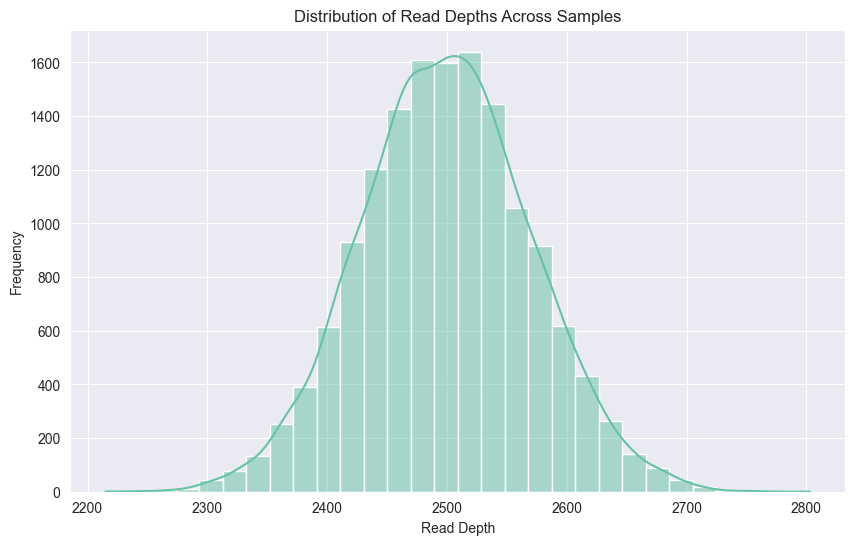

In [40]:
# plot a distribution of read depths
plt.figure(figsize=(10, 6))
sns.histplot(read_depths_df["read_depth"], bins=30, kde=True)
plt.title("Distribution of Read Depths Across Samples")
plt.xlabel("Read Depth")
plt.ylabel("Frequency")
plt.show()

#### Sequencing Depth Assessment Summary

**Key Observation**: Read depths vary across samples (range: ~2,300 - 2,700 reads per sample)

**Bias Concern**: 
- Samples with higher read depths (2,700) will appear to have higher alpha diversity
- Samples with lower read depths (2,300) may miss rare taxa, appearing less diverse
- This technical variation can create **false biological signals** in diversity comparisons

**Impact on Analysis**:
- Coffee consumption groups might appear to differ in diversity due to sequencing depth differences rather than true biological differences
- Statistical tests comparing alpha diversity between groups become unreliable
- Need normalization to ensure fair comparison across samples

**Next Steps**: Evaluate normalization strategies (rarefaction, relative abundance, or CSS normalization) before proceeding to alpha diversity calculations.

In [41]:
# Relative Abundance Normalization
print("Converting to relative abundance...")

# Get feature columns (all columns except the first one which contains feature IDs)
feature_columns = [col for col in feature_table.columns if col != feature_table.columns[0]]
feature_id_col = feature_table.columns[0]

# Convert feature table to pandas for easier manipulation
feature_table_pd = feature_table.to_pandas()
feature_table_pd.set_index(feature_id_col, inplace=True)

# Calculate relative abundance (divide each sample by its total read count)
feature_table_rel_abund = feature_table_pd.div(feature_table_pd.sum(axis=0), axis=1)

# Verify normalization worked (each column should sum to 1.0)
column_sums = feature_table_rel_abund.sum(axis=0)
print(f"Column sums after normalization (should all be 1.0):")
print(f"Min: {column_sums.min():.6f}, Max: {column_sums.max():.6f}")
print(f"All columns sum to 1.0: {np.allclose(column_sums, 1.0)}")

# Convert back to polars format for consistency with rest of analysis
feature_table_rel_abund_reset = feature_table_rel_abund.reset_index()
feature_table_rel_abund_pl = pl.from_pandas(feature_table_rel_abund_reset)

print(f"\nRelative abundance table shape: {feature_table_rel_abund_pl.shape}")
print("\nFirst few rows of relative abundance table:")
print(feature_table_rel_abund_pl.head())

Converting to relative abundance...
Column sums after normalization (should all be 1.0):
Min: 1.000000, Max: 1.000000
All columns sum to 1.0: True

Relative abundance table shape: (500, 14962)

First few rows of relative abundance table:
shape: (5, 14_962)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ #OTU ID  ┆ Sample_00 ┆ Sample_00 ┆ Sample_00 ┆ … ┆ Sample_14 ┆ Sample_14 ┆ Sample_14 ┆ Sample_14 │
│ ---      ┆ 000       ┆ 001       ┆ 002       ┆   ┆ 996       ┆ 997       ┆ 998       ┆ 999       │
│ str      ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ OTU_0000 ┆ 0.00287   ┆ 0.000849  ┆ 0.000404  ┆ … ┆ 0.003135  ┆ 0.001672  ┆ 0.001184  ┆ 0.001228  │
│ OTU_0001 ┆ 0.00123   ┆ 0.003818  ┆

Creating histogram of relative abundances across all samples and OTUs...
Total abundance values: 7480500
Number of samples: 14961
Number of OTUs: 500

Abundance statistics:
Zero abundances: 234027 (3.1%)
Non-zero abundances: 7246473 (96.9%)
Min non-zero: 0.00035676
Max abundance: 0.013377
Median non-zero: 0.00193723
551546


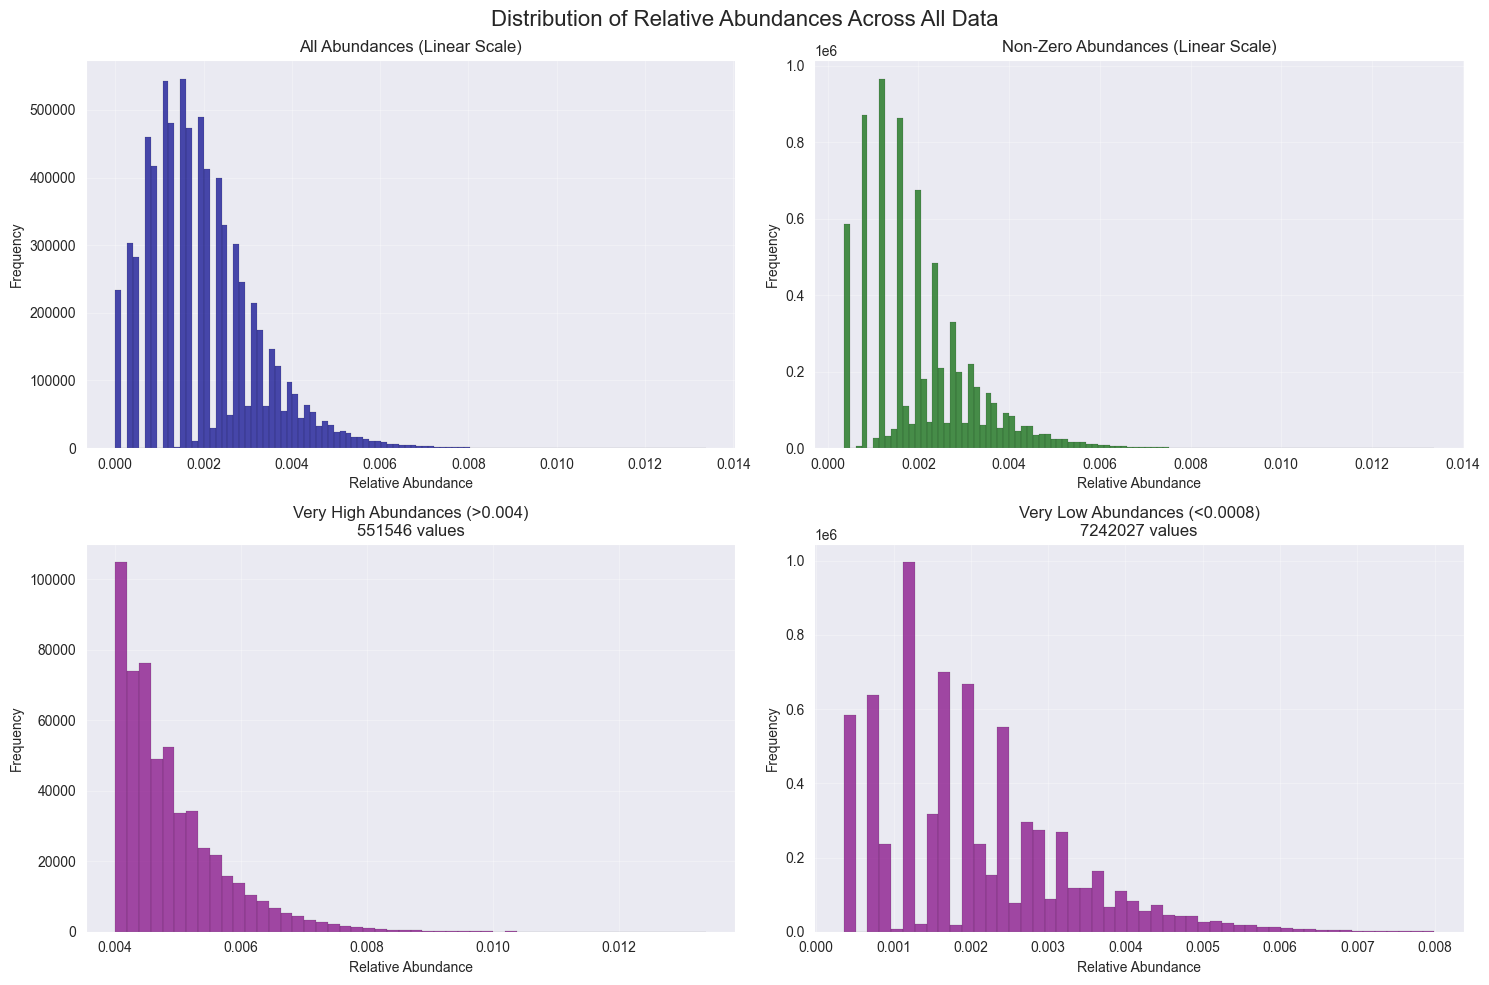


Non-zero abundance percentiles:
1th percentile: 0.00038790
5th percentile: 0.00040437
10th percentile: 0.00077912
25th percentile: 0.00118765
50th percentile: 0.00193723
75th percentile: 0.00277888
90th percentile: 0.00369762
95th percentile: 0.00439648
99th percentile: 0.00578991


In [42]:
# Create histogram of relative abundances across all data
print("Creating histogram of relative abundances across all samples and OTUs...")

# Get all relative abundance values from the entire dataset
all_abundances = []

# Extract all abundance values (excluding the feature ID column)
sample_columns = [col for col in feature_table_rel_abund_pl.columns if col != feature_table_rel_abund_pl.columns[0]]

for col in sample_columns:
    abundances = feature_table_rel_abund_pl[col].to_list()
    all_abundances.extend(abundances)

print(f"Total abundance values: {len(all_abundances)}")
print(f"Number of samples: {len(sample_columns)}")
print(f"Number of OTUs: {feature_table_rel_abund_pl.height}")

# Remove zeros for better visualization of the distribution
non_zero_abundances = [x for x in all_abundances if x > 0]
zero_count = len(all_abundances) - len(non_zero_abundances)

print(f"\nAbundance statistics:")
print(f"Zero abundances: {zero_count} ({zero_count/len(all_abundances)*100:.1f}%)")
print(f"Non-zero abundances: {len(non_zero_abundances)} ({len(non_zero_abundances)/len(all_abundances)*100:.1f}%)")
print(f"Min non-zero: {min(non_zero_abundances):.8f}")
print(f"Max abundance: {max(non_zero_abundances):.6f}")
print(f"Median non-zero: {sorted(non_zero_abundances)[len(non_zero_abundances)//2]:.8f}")

# Create comprehensive histogram visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Relative Abundances Across All Data', fontsize=16)

# 1. All abundances (including zeros) - linear scale
axes[0,0].hist(all_abundances, bins=100, color='darkblue', alpha=0.7, edgecolor='black', linewidth=0.1)
axes[0,0].set_title('All Abundances (Linear Scale)')
axes[0,0].set_xlabel('Relative Abundance')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# 2. Non-zero abundances only - linear scale
axes[0,1].hist(non_zero_abundances, bins=100, color='darkgreen', alpha=0.7, edgecolor='black', linewidth=0.1)
axes[0,1].set_title('Non-Zero Abundances (Linear Scale)')
axes[0,1].set_xlabel('Relative Abundance')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

# 3. High abundances (zoomed in)
very_high = [x for x in non_zero_abundances if x > 0.004]
print(len(very_high))
if very_high:
    axes[1,0].hist(very_high, bins=50, color='purple', alpha=0.7, edgecolor='black', linewidth=0.1)
    axes[1,0].set_title(f'Very High Abundances (>0.004)\n{len(very_high)} values')
    axes[1,0].set_xlabel('Relative Abundance')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].grid(True, alpha=0.3)
else:
    axes[1,0].text(0.5, 0.5, 'No abundances < 0.001', 
                   transform=axes[1,0].transAxes, ha='center', va='center')

plt.tight_layout()

# 4. Very low abundances (zoomed in)
very_low = [x for x in non_zero_abundances if x < 0.008]
if very_low:
    axes[1,1].hist(very_low, bins=50, color='purple', alpha=0.7, edgecolor='black', linewidth=0.1)
    axes[1,1].set_title(f'Very Low Abundances (<0.0008)\n{len(very_low)} values')
    axes[1,1].set_xlabel('Relative Abundance')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].grid(True, alpha=0.3)
else:
    axes[1,1].text(0.5, 0.5, 'No abundances < 0.001', 
                   transform=axes[1,1].transAxes, ha='center', va='center')

plt.tight_layout()
plt.show()

# Print distribution percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print(f"\nNon-zero abundance percentiles:")
sorted_abundances = sorted(non_zero_abundances)
for p in percentiles:
    idx = int(len(sorted_abundances) * p / 100) - 1
    if idx >= 0:
        print(f"{p}th percentile: {sorted_abundances[idx]:.8f}")

### Observations on Abundance Distribution Patterns

The histogram of all relative abundances reveals a clear bimodal distribution. The first distribution peaks at higher relative abundance values and represents a smaller proportion of the data. The second distribution peaks at much lower relative abundance values and is substantially taller, indicating it contains the majority of abundance measurements.

However, there's a striking and unusual pattern in this lower abundance distribution: approximately every third bin appears empty, creating a regular "gap-fill-gap-fill" pattern throughout the range. This discretization artifact becomes even more apparent when examining only non-zero abundances, where what initially appeared as two large distributions actually resolves into what looks like three separate distributions, two of which exhibit the same strange gap-fill-gap-fill pattern.

Setting aside the discretization artifacts, the non-zero abundances plot appears to show a trimodal distribution. This raises the interesting possibility that each of these three peaks could correspond to the abundance patterns characteristic of each coffee consumption group (none, occasional, daily), suggesting that coffee consumption may be creating distinct abundance signatures in the microbiome data that are detectable even in this overall distribution view.